In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from utils.plotting import aligned_imshow_cbar
from utils.models import IsoelasticWealthChange, Gamble, IsoelasticAgent

mpl.rcParams["font.size"] = 15

In [2]:
def find_indifference_eta(g1, g2, x, eta_l=-10, eta_r=10, precision=1e-7):
    """Estimate indifference eta given a pair of gambles.
    
    Eta indifference is the risk attitude/aversion value for which an agent is 
    indifferent between choosing two gambles. Inspecting indifference eta allow
    to visualize gamble space emphasisising choice discrepancies between agents.
    
    g1 (Gamble):
        First gamble.
    g2 (Gamble):
        Second gamble.
    x (float):
        Agent's wealth.
    eta_l (float):
        Lower bound for eta indifference search.
    eta_r (float):
        Upper bound for eta indifference search.
    precision (float):
        Conversion precision criterion. 
    """
    eta_range = [eta_l, eta_r]
    while True:
        l = IsoelasticAgent(eta_range[0], x).gamble_difference(g1, g2)
        r = IsoelasticAgent(eta_range[1], x).gamble_difference(g1, g2)
        eta_m = (eta_range[0] + eta_range[1]) / 2
        
        # both signs are the same, i.e., strict preference regardless of eta
        if np.sign(l * r) == 1:
            return np.sign(l) * np.inf

        # we converged at the solution
        if np.abs(eta_range[0] - eta_range[1]) < precision:
            return eta_m      
        
        # improve range
        m = IsoelasticAgent(eta_m, x).gamble_difference(g1, g2)
        if np.sign(m) == np.sign(l):
            eta_range[0] = eta_m
        else:
            eta_range[1] = eta_m

### Settings
- `wealth`: agent's current wealth
- `eta_dynamic`: simulated wealth dynamics
- `eta_bounds`: bounds for indifference eta search, indifference eta values outside of bounds won't be discovered
- `gamma_range`: growth rates for fractals (controls granularity of the search and gamble space sampling)
- `ref_gamble_idx`: matrix indices for reference gamble

In [3]:
wealth = 1000
eta_dynamic = 1                     
eta_bounds = [-1, 1]
gamma_range = np.linspace(-1, 1, 51)
ref_gamble_idx = [25, 25]

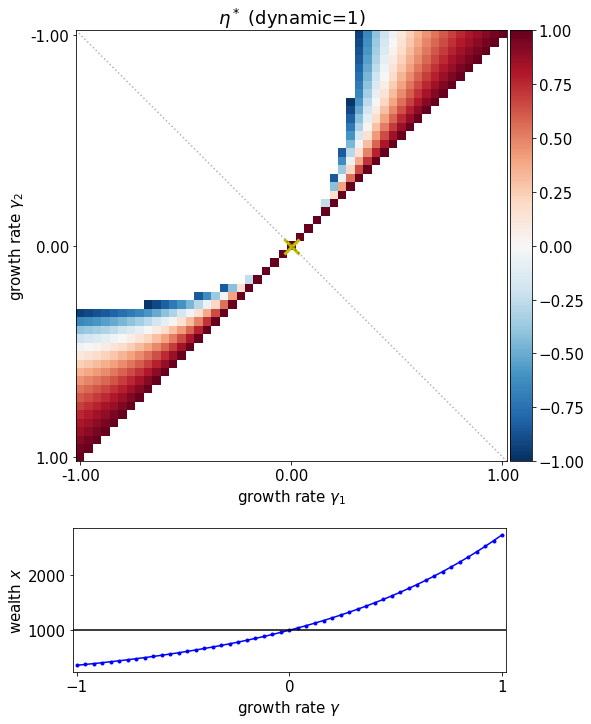

In [4]:
# Create fractals and reference gamble
fractals = [IsoelasticWealthChange(g, eta=eta_dynamic) for g in gamma_range]
n_fractals = len(fractals)
ref_g = Gamble(fractals[ref_gamble_idx[0]], fractals[ref_gamble_idx[1]])

eta_indiff = np.zeros((n_fractals, n_fractals))
for i in range(n_fractals):
    for j in range(n_fractals):
        g = Gamble(fractals[i], fractals[j])
        eta_indiff[i, j] = find_indifference_eta(
            g1=g, 
            g2=ref_g,
            x=wealth, 
            eta_l=eta_bounds[0], 
            eta_r=eta_bounds[1]
        )
        
fig, (ax1, ax2) = plt.subplots(
    figsize=(10, 10), 
    nrows=2,
    gridspec_kw={'height_ratios': [3, 1]}
)

# Top panel (indifference eta)
im = ax1.imshow(eta_indiff, clim=eta_bounds, cmap="RdBu_r", origin="upper")
ax1.plot(*ref_gamble_idx, 'x', ms=15, mec='y', mew=3)
ax1.plot([-.5, n_fractals -.5], [-.5, n_fractals -.5], "k:", alpha=0.3)
aligned_imshow_cbar(ax1, im)

gamma_mid = (gamma_range[0] + gamma_range[-1]) / 2
gamma_step = gamma_range[1] - gamma_range[0]

# Ticks and labels
ax1.set_xlabel("growth rate $\gamma_1$")
ax1.set_ylabel("growth rate $\gamma_2$")
ticks = np.linspace(0, n_fractals - 1, 3)
tickvalues = (gamma_range[0], gamma_mid, gamma_range[-1])
ticklabels = [f"{g:.2f}" for g in tickvalues]
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ticklabels)
ax1.set_yticklabels(ticklabels)
ax1.set_title(f"$\eta^*$ (dynamic={eta_dynamic})")

# Bottom panel (wealth change)
plt.tight_layout()
pos = ax2.get_position()
pos.x0 = pos.x0 + .12
pos.x1 = pos.x1 - .16
ax2.set_position(pos)

ax2.plot(gamma_range, [f(wealth) for f in fractals], ".-", color="b")
ax2.axhline(wealth, color="k")

ax2.set_xlim([gamma_range[0] - gamma_step / 2, 
              gamma_range[-1] + gamma_step / 2])
ax2.set_xticks(tickvalues)
ax2.set_ylabel("wealth $x$")
ax2.set_xlabel("growth rate $\gamma$")

plt.show()